# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

GANs were [first reported on](https://arxiv.org/abs/1406.2661) in 2014 from Ian Goodfellow and others in Yoshua Bengio's lab. Since then, GANs have exploded in popularity. Here are a few examples to check out:

* [Pix2Pix](https://affinelayer.com/pixsrv/) 
* [CycleGAN & Pix2Pix in PyTorch, Jun-Yan Zhu](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)
* [A list of generative models](https://github.com/wiseodd/generative-models)

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes "fake" data to pass to the discriminator. The discriminator also sees real training data and predicts if the data it's received is real or fake. 
> * The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real, training data. 
* The discriminator is a classifier that is trained to figure out which data is real and which is fake. 

What ends up happening is that the generator learns to make data that is indistinguishable from real data to the discriminator.

<img src='gan_img/gan_pipeline.png' width=70% />

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector that the generator uses to construct its fake images. This is often called a **latent vector** and that vector space is called **latent space**. As the generator trains, it figures out how to map latent vectors to recognizable images that can fool the discriminator.

If you're interested in generating only new images, you can throw out the discriminator after training. In this notebook, I'll show you how to define and train these adversarial networks in PyTorch and generate new images!

In [4]:
# Imports

%matplotlib inline

import numpy as np
import torch 
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

In [2]:
num_workers = 0 #number of subprocesses
batch_size = 64 # Samples per batch
transform = transforms.ToTensor()

#Download the dataset
train_data = datasets.MNIST(root='data', 
                            train=True, 
                            download=True,
                            transform=transform)

#Increase Train Loader
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           num_workers=num_workers)


### Visualize the data


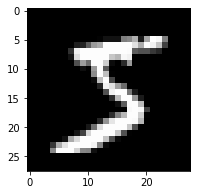

In [3]:
#obtain one batch of training images
data_iter = iter(train_loader)
images, labels = data_iter.next()
images = images.numpy()

sample = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(sample, cmap='gray')

---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

The discriminator network is going to be a pretty typical linear classifier. To make this network a universal function approximator, we'll need at least one hidden layer, and these hidden layers should have one key attribute:
> All hidden layers will have a [Leaky ReLu](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU) activation function applied to their outputs.

<img src='gan_img/gan_network.png' width=70% />

#### Leaky ReLu

We should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.

<img src='gan_img/leaky_relu.png' width=40% />

#### Sigmoid Output

We'll also take the approach of using a more numerically stable loss function on the outputs. Recall that we want the discriminator to output a value 0-1 indicating whether an image is _real or fake_. 
> We will ultimately use [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), which combines a `sigmoid` activation function **and** and binary cross entropy loss in one function. 

So, our final output layer should not have any activation function applied to it.